# Name: Nhat Minh Dang
# ID: 222172836
# SIT 378 

# Effect of Band Frequency Removal on Model Accuracy

## 1) Imported library:
These are the library required to process the data:
Note that the code only work when the Model is saved in the code directory. 

In [4]:
import librosa
import librosa.display
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import csv
import matplotlib.pyplot as plt
import os
import glob
import pandas as pd
import scipy.signal


## 2) Setting:
These are the parameters that is required to run the code. You can add as many desired classes as possible (remember to adjust in Accuracy Calcuation function). The frequency range is set based on my suggestion for the best outcome:

In [6]:
audio_directory_path = "Sound/Aslan"
desired_class = "Roaring cats (lions, tigers)"
desired_class_1 = ""
desired_class_2 = ""
min_range = 0
max_range = 7900
distance = 100
min_test = 0
max_test = 6000
distance_test = 3000

# 3) File Check:
To check whether the input directory is correct or not, the code below will count the number of files found in that directory.

In [8]:
def count_files_in_directory(directory_path):
    try:
        all_items = os.listdir(directory_path)
        files = [item for item in all_items if os.path.isfile(os.path.join(directory_path, item))]
        return len(files)
    except FileNotFoundError:
        print(f"Directory not found: {directory_path}")
        return 0
    except PermissionError:
        print(f"Permission denied to access: {directory_path}")
        return 0

file_count = count_files_in_directory(audio_directory_path)
print(f"Number of files in '{audio_directory_path}': {file_count}")


Number of files in 'Sound/Aslan': 45


# 4) Basic Codes:
These are the basic code to produce the standard result for comparison, which includes:
- Audio processing: Load audio file and resample it, followed by clipping the waveform amplitude from -1 to 1 for normalization.\
- Load the YAMNet model in the saved directory.
- Load the class Map.
- Perform preduction.
- Compute the score and return the most probability prediction.
- Process all audio files (in .wav format).
- Feature visualization: Demonstrate audio files in Waveform, Log Mel Spectrogram and Frequency Spectrogram.
- Calculate accuracy: Check and count the result that match the setting above.

In [10]:
def preprocess_audio(file_path, target_sample_rate=16000):
    """
    Load and preprocess the audio file by applying a bandstop filter to remove a specific frequency range.
    Args:
        file_path (str): Path to the audio file.
        target_sample_rate (int): Desired sample rate for the audio.
    Returns:
        audio (numpy.ndarray): The preprocessed audio signal.
    """
    audio, sr = librosa.load(file_path, sr=target_sample_rate)
    audio = np.clip(audio, -1.0, 1.0)
    return audio

def load_yamnet_model(model_path='Model'):
    """
    Load the YAMNet model from the local directory.
    Args:
        model_path (str): Path to the directory containing the YAMNet model.
    Returns:
        model: Loaded YAMNet model.
    """
    model = hub.load(model_path)
    return model


def load_class_map(file_path='Model/assets/yamnet_class_map.csv'):
    """
    Load the class labels map from a CSV file.
    Args:
        file_path (str): Path to the CSV file containing the class map.
    Returns:
        dict: A dictionary mapping class indices to class names.
    """
    class_map = {}
    with open(file_path, 'r') as f:
        reader = csv.reader(f)
        next(reader)  
        
        for row in reader:
            class_index = int(row[0]) 
            class_name = row[2]       
            class_map[class_index] = class_name
    
    return class_map

def predict_with_yamnet(model, waveform):
    scores, embeddings, log_mel_spectrogram = model(waveform)
    return scores, embeddings, log_mel_spectrogram

def aggregate_scores(scores):
    aggregated_scores = np.mean(scores, axis=0)
    return aggregated_scores

def get_top_prediction(aggregated_scores, class_map):
    top_index = np.argmax(aggregated_scores)
    top_class = class_map[top_index]
    top_probability = aggregated_scores[top_index]   
    return top_class, top_probability

def process_audio_directory(directory_path, yamnet_model, class_map):
    """
    Process all .wav audio files in the given directory.
    Args:
        directory_path (str): Path to the directory containing .wav files.
        yamnet_model: The YAMNet model instance.
        class_map (dict): Mapping of class indices to class names.
    Returns:
        results (list): List of tuples containing file name, predicted class, and probability.
    """
    results = []
    wav_files = glob.glob(os.path.join(directory_path, '*.wav'))
    
    for wav_file in wav_files:
        try:
            waveform = preprocess_audio(wav_file)
            scores, embeddings, log_mel_spectrogram = predict_with_yamnet(yamnet_model, waveform)
            aggregated_scores = aggregate_scores(scores)
            top_class, top_probability = get_top_prediction(aggregated_scores, class_map)
            results.append((os.path.basename(wav_file), top_class, top_probability))      
        except Exception as e:
            print(f"Error processing file {wav_file}: {e}")
    
    return results


def display_audio_features(waveform, log_mel_spectrogram, file_name):
    """
    Displays the waveform, log mel spectrogram, frequency spectrum, and MFCC for a given audio file.
    Args:
        waveform (numpy.ndarray): The waveform of the audio.
        log_mel_spectrogram (tensorflow.Tensor or numpy.ndarray): The log mel spectrogram.
        sample_rate (int): The sampling rate of the audio.
        file_name (str): Name of the audio file.
    """
    sample_rate = 16000
    if isinstance(log_mel_spectrogram, tf.Tensor):
        log_mel_spectrogram = log_mel_spectrogram.numpy()
    n = len(waveform)
    freq_spectrum = np.abs(np.fft.fft(waveform))[:n // 2]
    frequencies = np.fft.fftfreq(n, 1 / sample_rate)[:n // 2]
    
    plt.figure(figsize=(16, 12))
    
    plt.subplot(4, 1, 1)
    plt.plot(waveform, color='blue')
    plt.title(f"Waveform - {file_name}")
    plt.xlabel("Samples")
    plt.ylabel("Amplitude")
    
    plt.subplot(4, 1, 2)
    plt.imshow(log_mel_spectrogram.T, aspect='auto', origin='lower', cmap='viridis')
    plt.title(f"Log Mel Spectrogram - {file_name}")
    plt.xlabel("Frames")
    plt.ylabel("Mel Bands")
    
    plt.subplot(4, 1, 3)
    plt.plot(frequencies, freq_spectrum, color='green')
    plt.title(f"Frequency Spectrum - {file_name}")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Amplitude")
    plt.xlim(0, sample_rate // 2) 
    
    plt.subplots_adjust(hspace=0.4)  
    plt.tight_layout()
    plt.show()
    
def calculate_accuracy(results):
    """
    Calculate the accuracy using collected result
    Args:
        results: Result collected.
    Returns:
        acc: Accuracy.
    """
    correct = 0
    acc = 0
    try:
        for file_name, predicted_class, probability in results:
            if predicted_class == desired_class or predicted_class == "Animal":
                correct += 1
        acc = correct / len(results) * 100
    except Exception as e:
            print(f"Error processing file: {e}")
    return acc



# 5) Execution code: 
These are the code to execute the function above, which includes processing files, model and display the first 3 examples:



Results:
File: aslan_1.wav - Predicted Class: Roaring cats (lions, tigers) - Probability: 0.6607


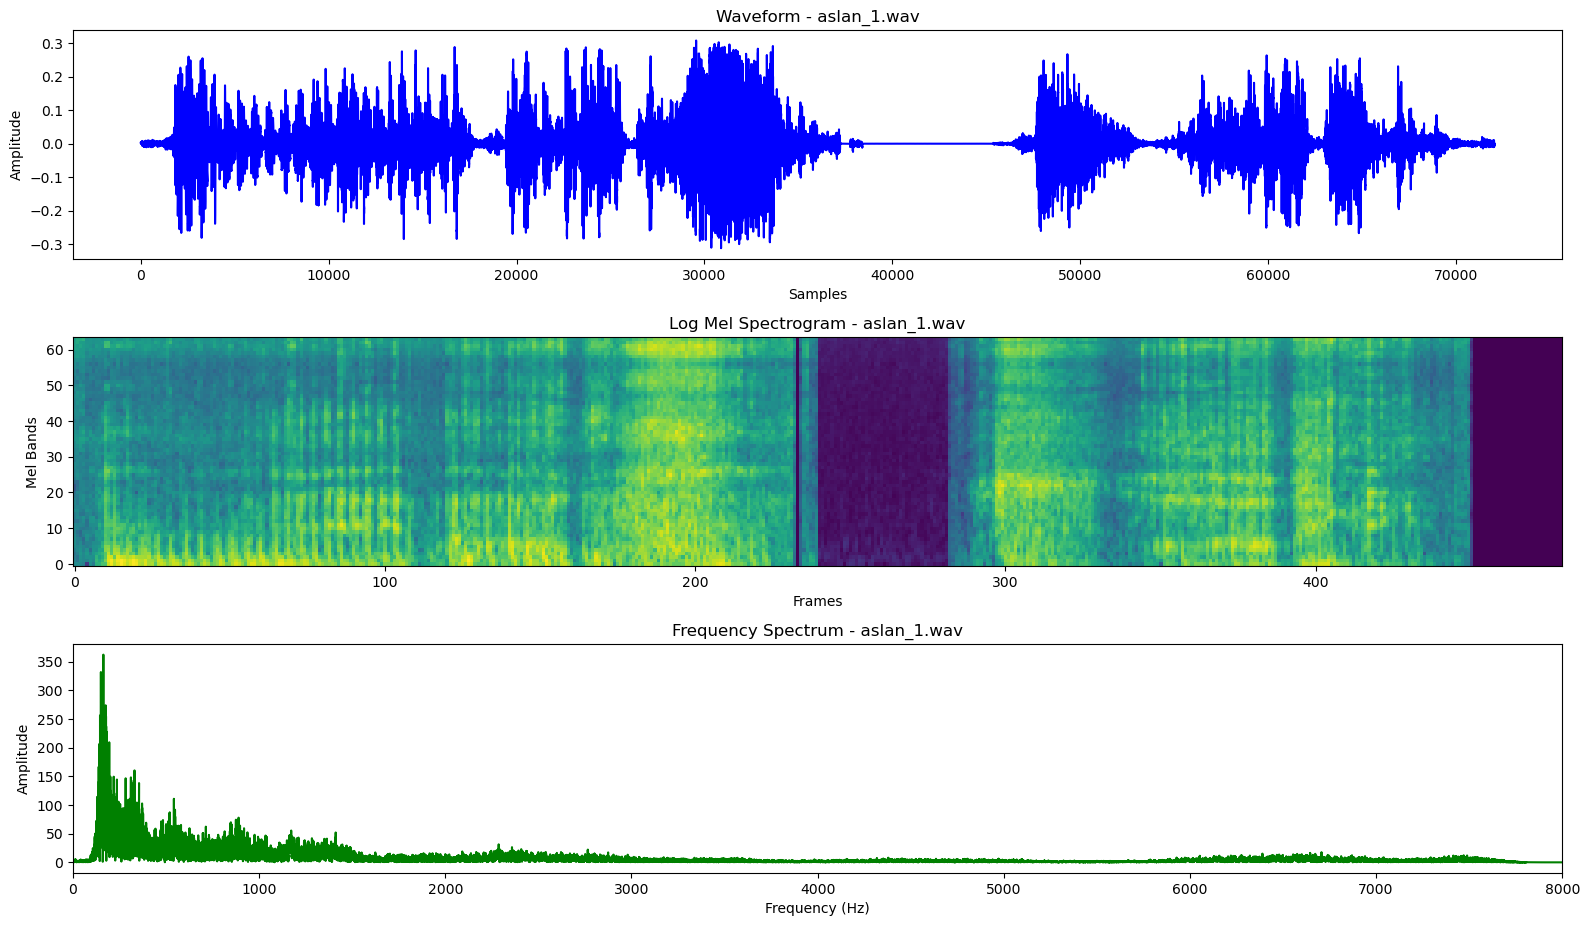

File: aslan_10.wav - Predicted Class: Roaring cats (lions, tigers) - Probability: 0.9941


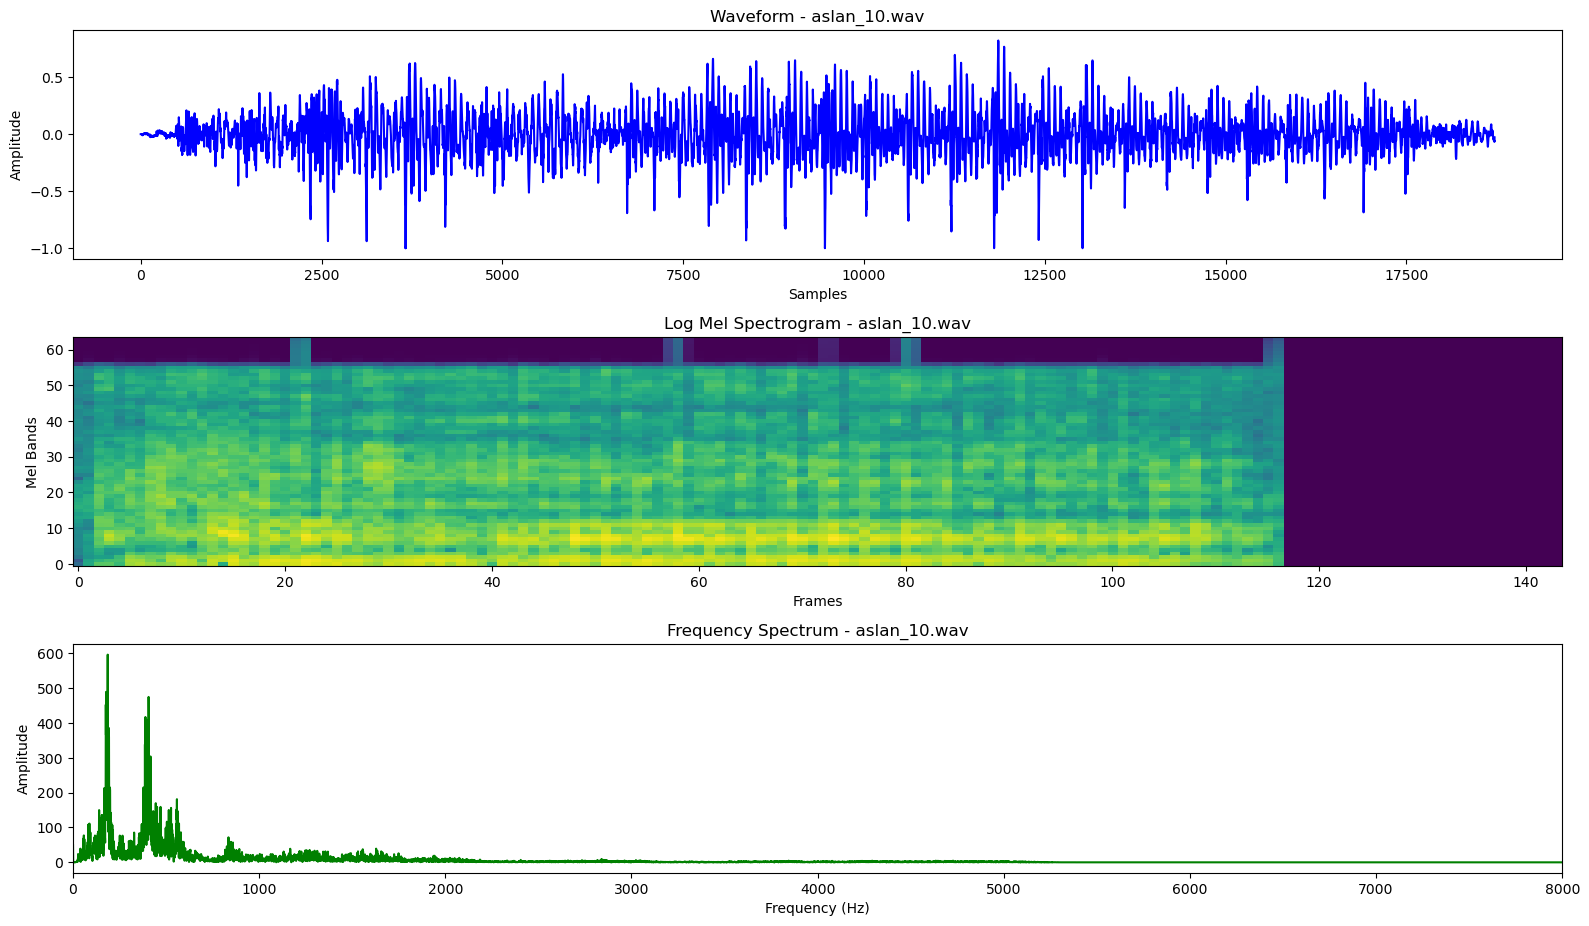

File: aslan_11.wav - Predicted Class: Roaring cats (lions, tigers) - Probability: 0.4172


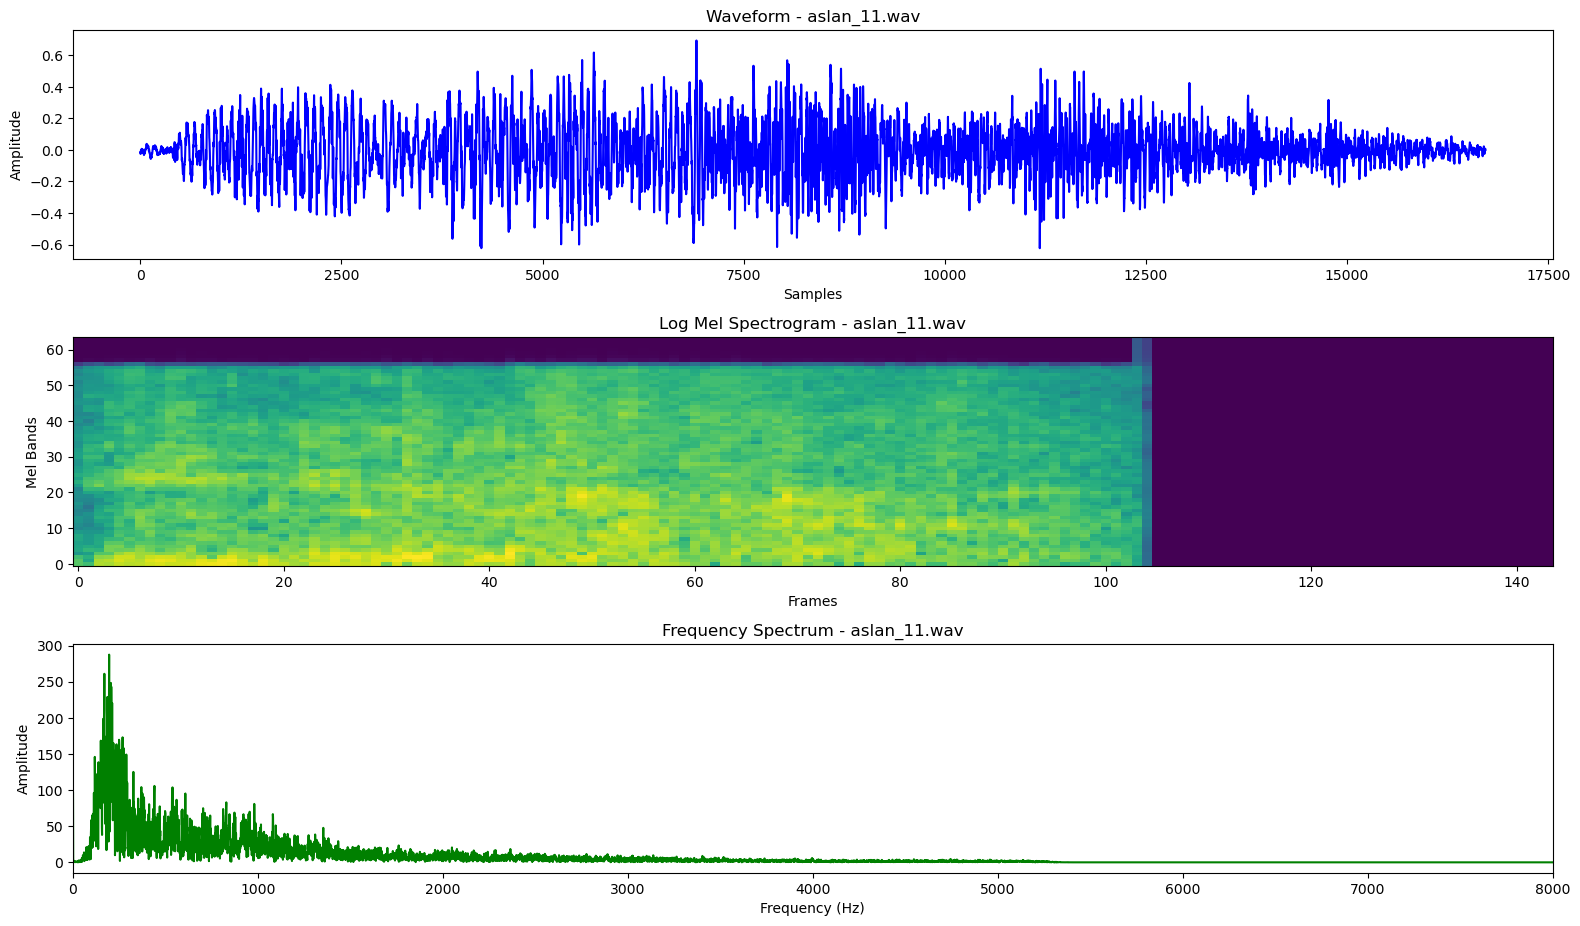

File: aslan_12.wav - Predicted Class: Roaring cats (lions, tigers) - Probability: 0.5964
File: aslan_13.wav - Predicted Class: Animal - Probability: 0.5781
File: aslan_14.wav - Predicted Class: Animal - Probability: 0.8432
File: aslan_15.wav - Predicted Class: Vehicle - Probability: 0.2488
File: aslan_16.wav - Predicted Class: Roaring cats (lions, tigers) - Probability: 0.7273
File: aslan_17.wav - Predicted Class: Animal - Probability: 0.7273
File: aslan_18.wav - Predicted Class: Roaring cats (lions, tigers) - Probability: 0.8477
File: aslan_19.wav - Predicted Class: Roar - Probability: 0.6806
File: aslan_2.wav - Predicted Class: Roaring cats (lions, tigers) - Probability: 0.9782
File: aslan_20.wav - Predicted Class: Animal - Probability: 0.5475
File: aslan_21.wav - Predicted Class: Animal - Probability: 0.7315
File: aslan_22.wav - Predicted Class: Roaring cats (lions, tigers) - Probability: 0.7273
File: aslan_23.wav - Predicted Class: Animal - Probability: 0.7273
File: aslan_24.wav - 

In [12]:
yamnet_model = load_yamnet_model()
class_map = load_class_map()

results = process_audio_directory(audio_directory_path, yamnet_model, class_map)

print("Results:")
for i, (file_name, predicted_class, probability) in enumerate(results):
    print(f"File: {file_name} - Predicted Class: {predicted_class} - Probability: {probability:.4f}")
    if i < 3:
        waveform = preprocess_audio(os.path.join(audio_directory_path, file_name))
        _, _, log_mel_spectrogram = predict_with_yamnet(yamnet_model, waveform)
        display_audio_features(waveform, log_mel_spectrogram, file_name)

# 6) Execution code: 
Print the accuraccy as standard.

In [14]:
print(f"Model Accuracy of: {audio_directory_path}")
print(calculate_accuracy(results))

Model Accuracy of: Sound/Aslan
88.88888888888889


# 7) Restart the model with Frequency Band Removal Methods:
For this experiment, there are new function added along with old functions with additional variables for frequency:
- Bandstop Filter: Apply Butterworth Filter.
- Update Preprocess audio and Process Audio Directory.

In [16]:
def preprocess_audio(file_path, target_sample_rate=16000, min_freq=None, max_freq=None):
    """
    Load and preprocess the audio file by applying a bandstop filter to remove a specific frequency range.
    Args:
        file_path (str): Path to the audio file.
        target_sample_rate (int): Desired sample rate for the audio.
        min_freq (float): The minimum frequency to remove (Hz).
        max_freq (float): The maximum frequency to remove (Hz).
    Returns:
        audio (numpy.ndarray): The preprocessed audio signal.
    """
    audio, sr = librosa.load(file_path, sr=target_sample_rate)
    audio = np.clip(audio, -1.0, 1.0)
    
    # Apply bandstop filtering if min_freq and max_freq are specified
    if min_freq and max_freq:
        audio = bandstop_filter(audio, sr, min_freq, max_freq)
    
    return audio

def bandstop_filter(audio, sample_rate, min_freq, max_freq):
    """
    Apply a bandstop filter to remove frequencies between min_freq and max_freq.
    Args:
        audio (numpy.ndarray): The audio signal.
        sample_rate (int): The sample rate of the audio.
        min_freq (float): The minimum frequency to remove (Hz).
        max_freq (float): The maximum frequency to remove (Hz).
    Returns:
        filtered_audio (numpy.ndarray): The bandstop filtered audio signal.
    """
    nyquist = 0.5 * sample_rate
    low = min_freq / nyquist
    high = max_freq / nyquist
    b, a = scipy.signal.butter(4, [low, high], btype='bandstop')
    filtered_audio = scipy.signal.filtfilt(b, a, audio)
    
    return filtered_audio

def process_audio_directory(directory_path, yamnet_model, class_map, min_freq, max_freq):
    """
    Process all .wav audio files in the given directory.
    Args:
        directory_path (str): Path to the directory containing .wav files.
        yamnet_model: The YAMNet model instance.
        class_map (dict): Mapping of class indices to class names.
    Returns:
        results (list): List of tuples containing file name, predicted class, and probability.
    """
    results = []
    wav_files = glob.glob(os.path.join(directory_path, '*.wav'))
    
    for wav_file in wav_files:
        try:
            waveform = preprocess_audio(wav_file, min_freq=min_freq, max_freq=max_freq)
            scores, embeddings, log_mel_spectrogram = predict_with_yamnet(yamnet_model, waveform)
            aggregated_scores = aggregate_scores(scores)
            top_class, top_probability = get_top_prediction(aggregated_scores, class_map)
            if len(results) < 1 and (min_freq == 0 or min_freq == 100):
                display_audio_features(waveform, log_mel_spectrogram, wav_files[:1])
            results.append((os.path.basename(wav_file), top_class, top_probability))
            
        except Exception as e:
            print(f"Error processing file {wav_file}: {e}")
    
    return results

# 8) Process the experiments for the long range of requency:
Test the model with different range of removed frequency, store and visualize the result in graph using the setting above.

In [18]:
def process_and_calculate_accuracy_for_ranges(directory_path, yamnet_model, class_map, target_sample_rate=16000):
    frequency_ranges = []
    accuracies = []
    
    for min_freq in range(min_range, max_range, distance):  
        max_freq = min_freq + distance
        print(f"Processing for frequency range: {min_freq}-{max_freq} Hz")
        results = process_audio_directory(directory_path, yamnet_model, class_map, min_freq, max_freq)
        accuracy = calculate_accuracy(results)
        frequency_ranges.append(f"{max_freq} Hz")
        accuracies.append(accuracy)
    
    results_df = pd.DataFrame({
        "Frequency Range": frequency_ranges,
        "Accuracy (%)": accuracies
    })
    
    return results_df

def plot_accuracy_vs_frequency_range(results_df):
    plt.figure(figsize=(15, 6))
    plt.plot(results_df["Frequency Range"], results_df["Accuracy (%)"], marker='o', color='b')
    plt.xticks(rotation=45, ha='right')
    plt.title("Accuracy vs Frequency Range")
    plt.xlabel("Frequency Range (Hz)")
    plt.ylabel("Accuracy (%)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


Processing for frequency range: 0-100 Hz


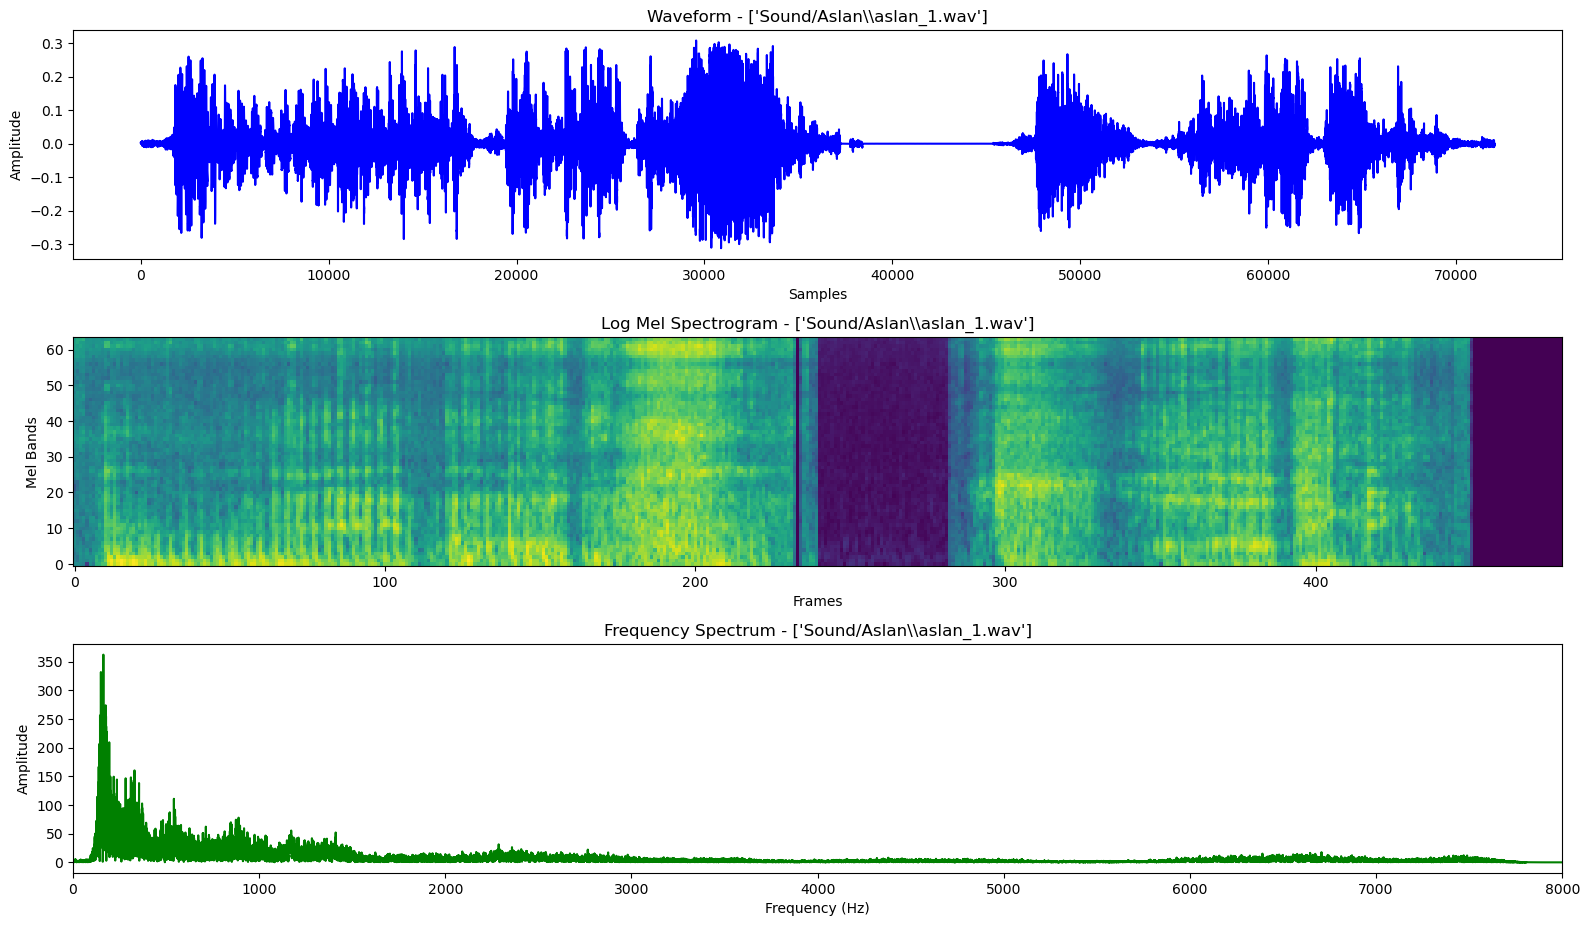

Processing for frequency range: 100-200 Hz


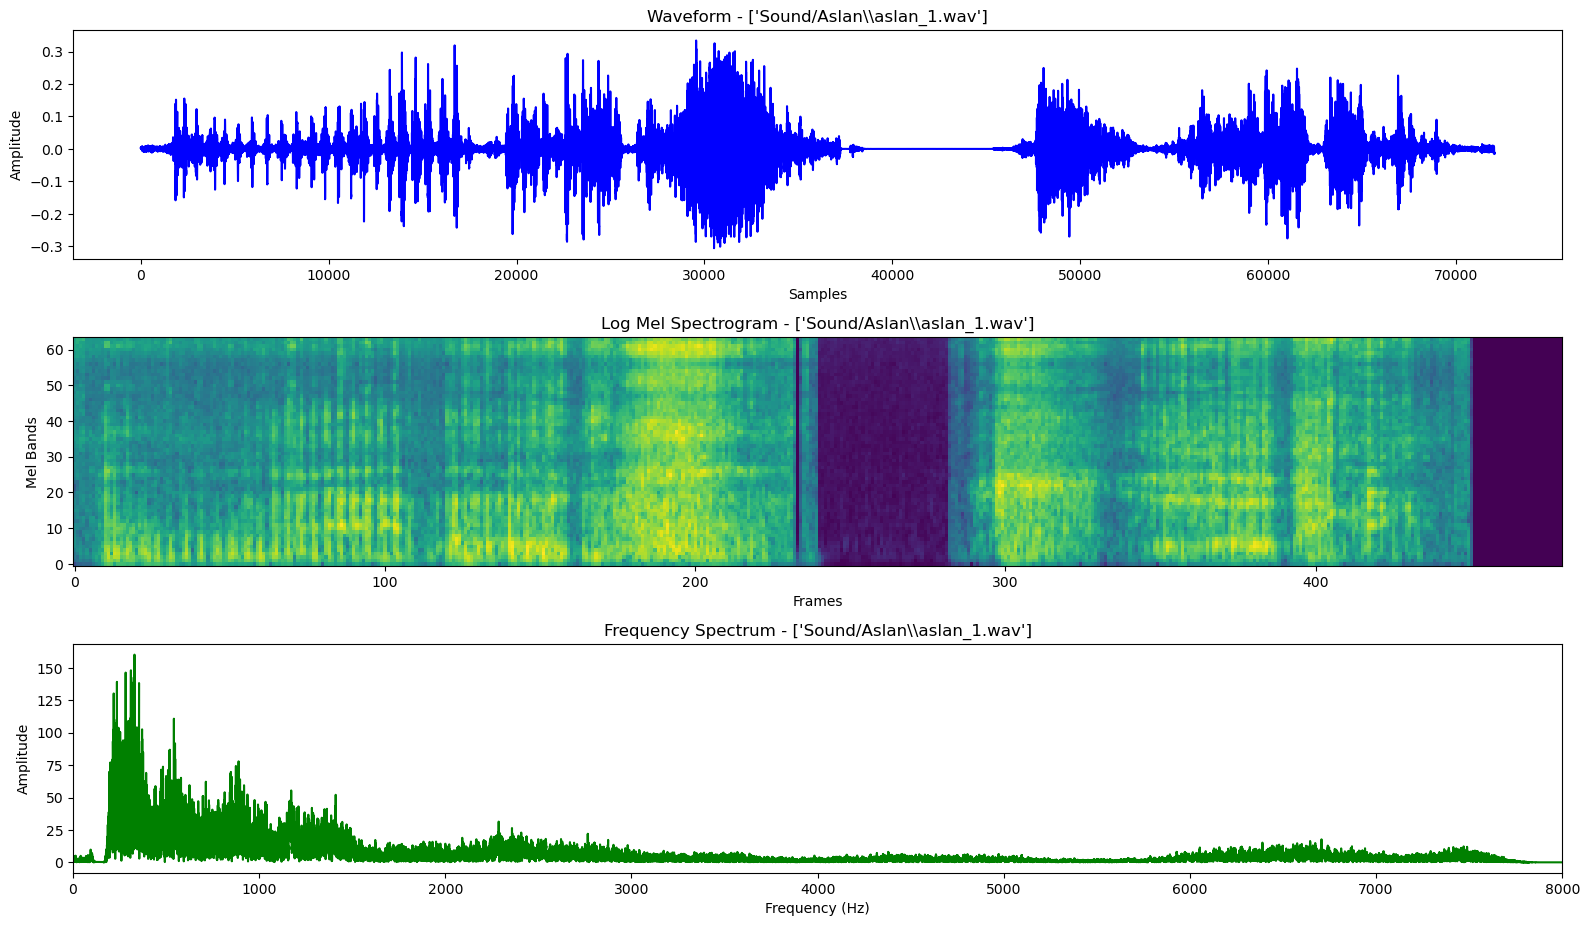

Processing for frequency range: 200-300 Hz
Processing for frequency range: 300-400 Hz
Processing for frequency range: 400-500 Hz
Processing for frequency range: 500-600 Hz
Processing for frequency range: 600-700 Hz
Processing for frequency range: 700-800 Hz
Processing for frequency range: 800-900 Hz
Processing for frequency range: 900-1000 Hz
Processing for frequency range: 1000-1100 Hz
Processing for frequency range: 1100-1200 Hz
Processing for frequency range: 1200-1300 Hz
Processing for frequency range: 1300-1400 Hz
Processing for frequency range: 1400-1500 Hz
Processing for frequency range: 1500-1600 Hz
Processing for frequency range: 1600-1700 Hz
Processing for frequency range: 1700-1800 Hz
Processing for frequency range: 1800-1900 Hz
Processing for frequency range: 1900-2000 Hz
Processing for frequency range: 2000-2100 Hz
Processing for frequency range: 2100-2200 Hz
Processing for frequency range: 2200-2300 Hz
Processing for frequency range: 2300-2400 Hz
Processing for frequency 

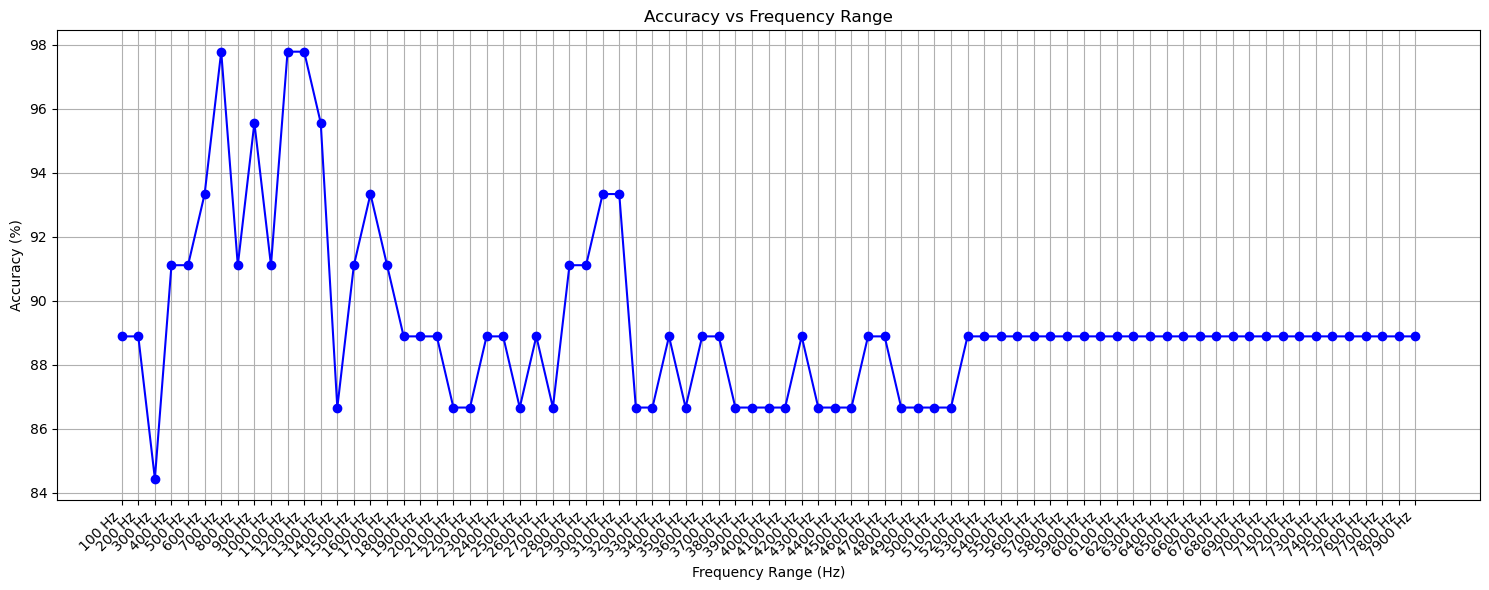

In [19]:
yamnet_model = load_yamnet_model()
class_map = load_class_map()
results_df = process_and_calculate_accuracy_for_ranges(audio_directory_path, yamnet_model, class_map)
print(results_df)
plot_accuracy_vs_frequency_range(results_df)

# 9) Verify the result using Bandpass Filter:
Modify the function with Butterworth filter for the outside range:

In [21]:
def preprocess_audio(file_path, target_sample_rate=16000, min_freq=None, max_freq=None):
    """
    Load and preprocess the audio file by applying a bandpass filter to retain a specific frequency range.
    Args:
        file_path (str): Path to the audio file.
        target_sample_rate (int): Desired sample rate for the audio.
        min_freq (float): The minimum frequency to retain (Hz).
        max_freq (float): The maximum frequency to retain (Hz).
    Returns:
        audio (numpy.ndarray): The preprocessed audio signal.
    """
    audio, sr = librosa.load(file_path, sr=target_sample_rate)
    audio = np.clip(audio, -1.0, 1.0)
    if min_freq and max_freq:
        audio = bandpass_filter(audio, sr, min_freq, max_freq)
    
    return audio

def bandpass_filter(audio, sample_rate, min_freq, max_freq):
    """
    Apply a bandpass filter to retain frequencies between min_freq and max_freq.
    Args:
        audio (numpy.ndarray): The audio signal.
        sample_rate (int): The sample rate of the audio.
        min_freq (float): The minimum frequency to retain (Hz).
        max_freq (float): The maximum frequency to retain (Hz).
    Returns:
        filtered_audio (numpy.ndarray): The bandpass filtered audio signal.
    """
    nyquist = 0.5 * sample_rate
    low = min_freq / nyquist
    high = max_freq / nyquist
    b, a = scipy.signal.butter(4, [low, high], btype='bandpass')
    filtered_audio = scipy.signal.filtfilt(b, a, audio)
    
    return filtered_audio

def process_audio_directory(directory_path, yamnet_model, class_map, min_freq, max_freq):
    """
    Process all .wav audio files in the given directory.
    Args:
        directory_path (str): Path to the directory containing .wav files.
        yamnet_model: The YAMNet model instance.
        class_map (dict): Mapping of class indices to class names.
    Returns:
        results (list): List of tuples containing file name, predicted class, and probability.
    """
    results = []
    
    wav_files = glob.glob(os.path.join(directory_path, '*.wav'))
    
    for wav_file in wav_files:
        try:
            waveform = preprocess_audio(wav_file, min_freq=min_freq, max_freq=max_freq)
            scores, embeddings, log_mel_spectrogram = predict_with_yamnet(yamnet_model, waveform)
            aggregated_scores = aggregate_scores(scores)
            top_class, top_probability = get_top_prediction(aggregated_scores, class_map)
            results.append((os.path.basename(wav_file), top_class, top_probability))            
        except Exception as e:
            print(f"Error processing file {wav_file}: {e}")
    
    return results


# 10) Visualize the affect of Bandpass Fitler to the Model:

In [23]:
def process_and_calculate_accuracy_for_ranges(directory_path, yamnet_model, class_map, target_sample_rate=16000):
    frequency_ranges = []
    accuracies = []
    
    for min_freq in range(min_test, max_test, distance_test): 
        max_freq = min_freq + distance_test
        print(f"Processing for frequency range: {min_freq}-{max_freq} Hz")
        results = process_audio_directory(directory_path, yamnet_model, class_map, min_freq, max_freq)
        accuracy = calculate_accuracy(results)
        frequency_ranges.append(f"{max_freq} Hz")
        accuracies.append(accuracy)
    results_df = pd.DataFrame({
        "Frequency Range": frequency_ranges,
        "Accuracy (%)": accuracies
    })
    
    return results_df

def plot_accuracy_vs_frequency_range(results_df):
    plt.figure(figsize=(15, 6))
    plt.plot(results_df["Frequency Range"], results_df["Accuracy (%)"], marker='o', color='b')
    plt.xticks(rotation=45, ha='right')
    plt.title("Accuracy vs Frequency Range")
    plt.xlabel("Frequency Range (Hz)")
    plt.ylabel("Accuracy (%)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


Processing for frequency range: 0-3000 Hz
Processing for frequency range: 3000-6000 Hz
  Frequency Range  Accuracy (%)
0         3000 Hz     88.888889
1         6000 Hz     22.222222


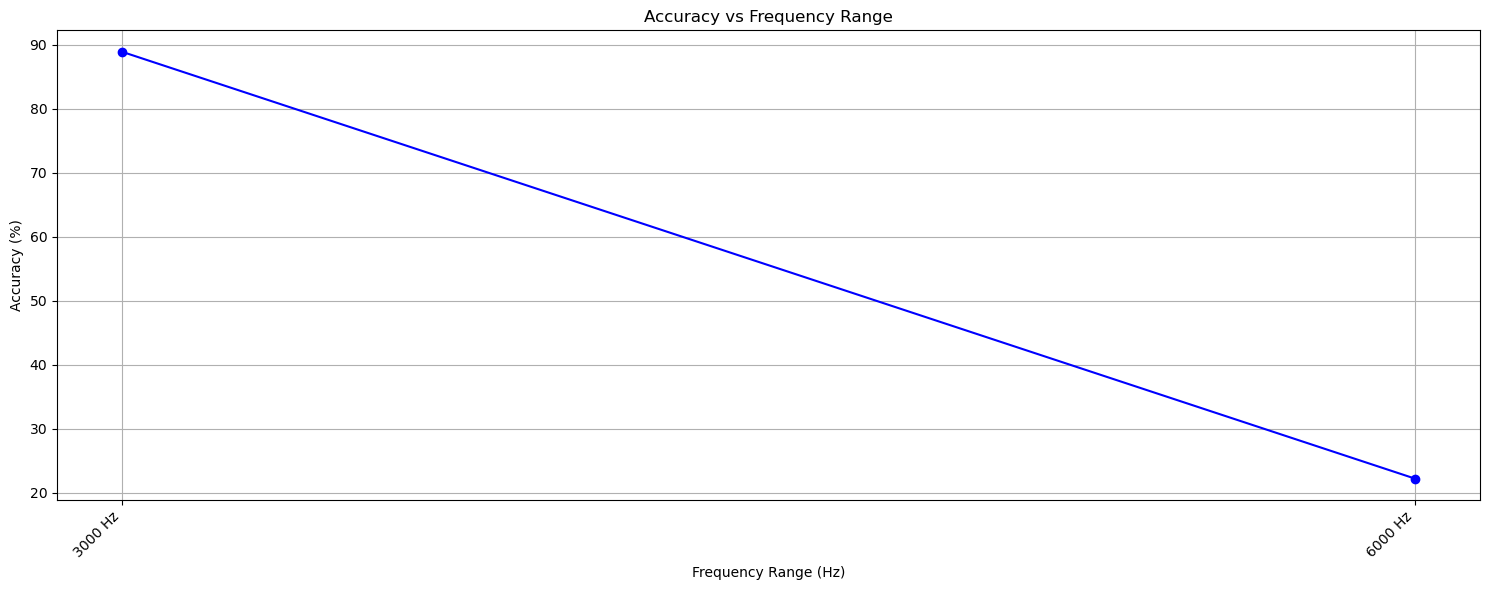

In [24]:
results_df = process_and_calculate_accuracy_for_ranges(audio_directory_path, yamnet_model, class_map)
print(results_df)
plot_accuracy_vs_frequency_range(results_df)